<a href="https://colab.research.google.com/github/Ashwin1999/COVID-19-Data-Mining/blob/nivethsaran/COVID_19_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np # linear algebra
import warnings
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import datetime
import matplotlib
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import warnings
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
import pickle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')



matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import dataset from this link: https://github.com/Ashwin1999/COVID-19-Data-Mining

# India Covid Data


In [2]:
files = [
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/complete.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/district_level_latest.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/nation_level_daily.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/patients_data.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/state_level_daily.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/state_level_latest.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/tests_day_wise.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/tests_state_wise.csv',
]

In [3]:
indiadaily=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/nation_level_daily.csv')
indiadaily['Date'] = indiadaily['Date'].str.slice(0,6) +' 2020'
indiadaily['Date']= indiadaily['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d %b %Y'))
indiadaily['Date']= pd.to_datetime(indiadaily['Date'])
print(indiadaily.dtypes)
indiadaily.tail()

Date               datetime64[ns]
Daily Confirmed             int64
Total Confirmed             int64
Daily Recovered             int64
Total Recovered             int64
Daily Deceased              int64
Total Deceased              int64
dtype: object


,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
185,2020-08-02,52672,1804857,40355,1187261,760,38180
186,2020-08-03,50488,1855345,43070,1230331,806,38986
187,2020-08-04,51282,1906627,51220,1281551,849,39835
188,2020-08-05,56626,1963253,45583,1327134,919,40754
189,2020-08-06,62170,2025423,50141,1377275,899,41653


In [4]:
complete = pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/complete.csv')
complete['Date']= pd.to_datetime(complete['Date'])
complete.rename(columns={'Name of State / UT':'State'},inplace=True)
complete['Death'] = complete['Death'].str.extract('(\d+)', expand=False)
complete['Death'] = complete['Death'].astype(int)
print(complete.dtypes)
complete.head()

Date                         datetime64[ns]
State                                object
Latitude                            float64
Longitude                           float64
Total Confirmed cases               float64
Death                                 int64
Cured/Discharged/Migrated           float64
New cases                             int64
New deaths                            int64
New recovered                         int64
dtype: object


,Date,State,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2.0,0,0.0,1,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3.0,0,0.0,1,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3.0,0,0.0,0,0,0


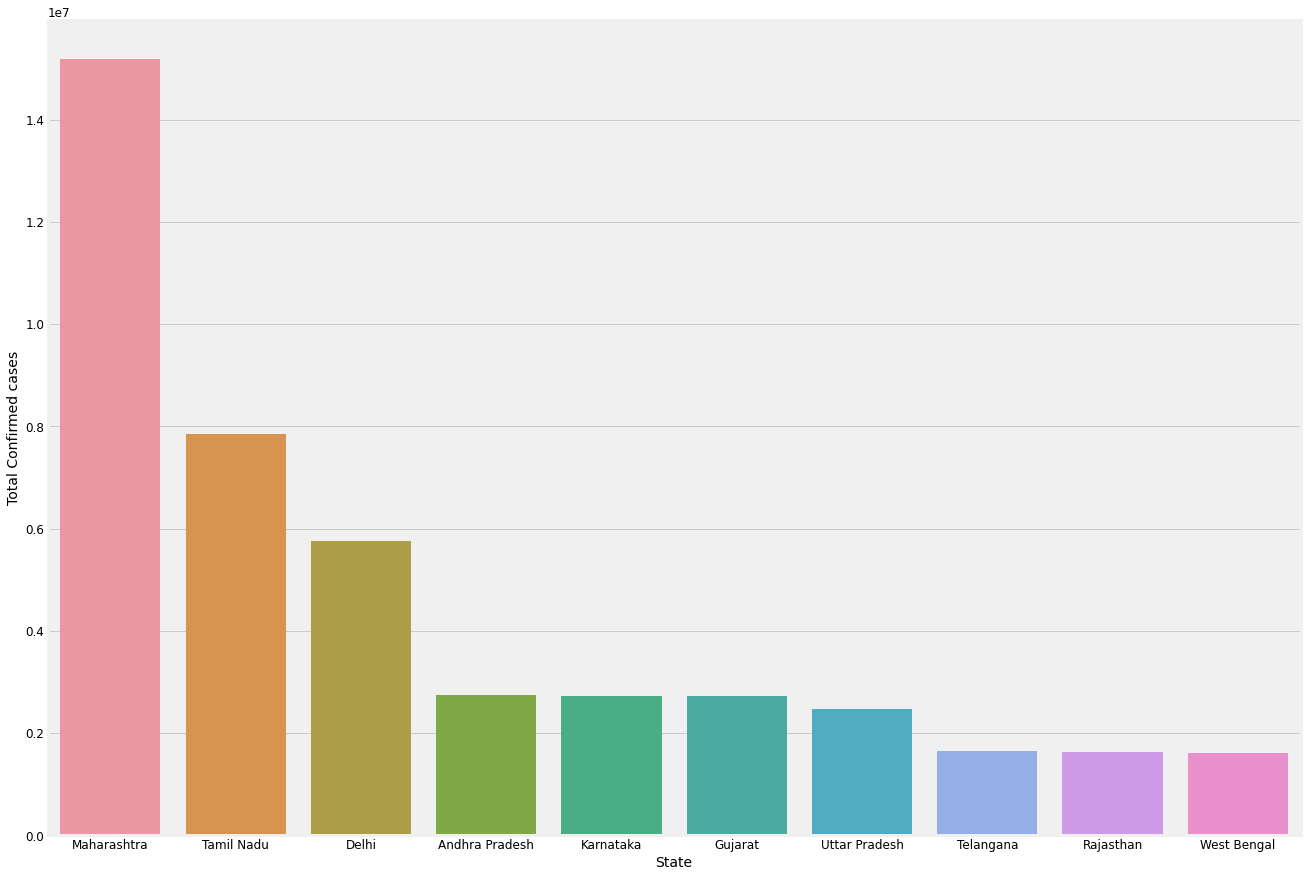

In [5]:
plt.figure(figsize=(20,15))
statewisedata=complete.groupby('State').sum()
statewisedata.reset_index(inplace=True)
statewisedata.sort_values(by='Total Confirmed cases',inplace=True,ascending=False)
sns.barplot(y='Total Confirmed cases',x='State',data=statewisedata.iloc[:10])
# # statewisedata.plot.bar(rot=0,figsize=(20,10))
# # statewisedata.plot.bar(rot=0,figsize=(20,10))

# plt.xticks(rotation=70)
# statewisedata.head()

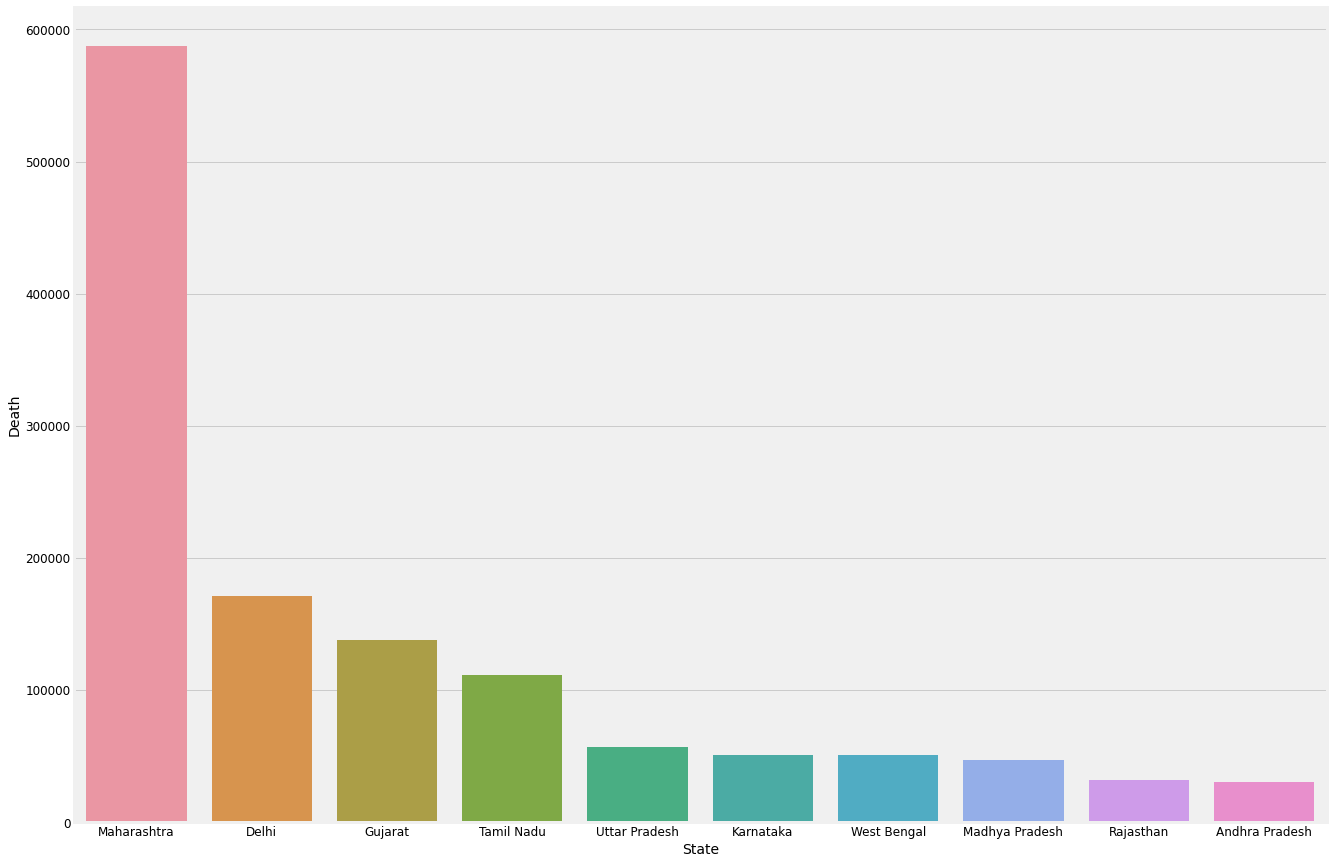

In [6]:
plt.figure(figsize=(20,15))
statewisedata=complete.groupby('State').sum()
statewisedata.reset_index(inplace=True)
statewisedata.sort_values(by='Death',inplace=True,ascending=False)
sns.barplot(y='Death',x='State',data=statewisedata.iloc[:10])

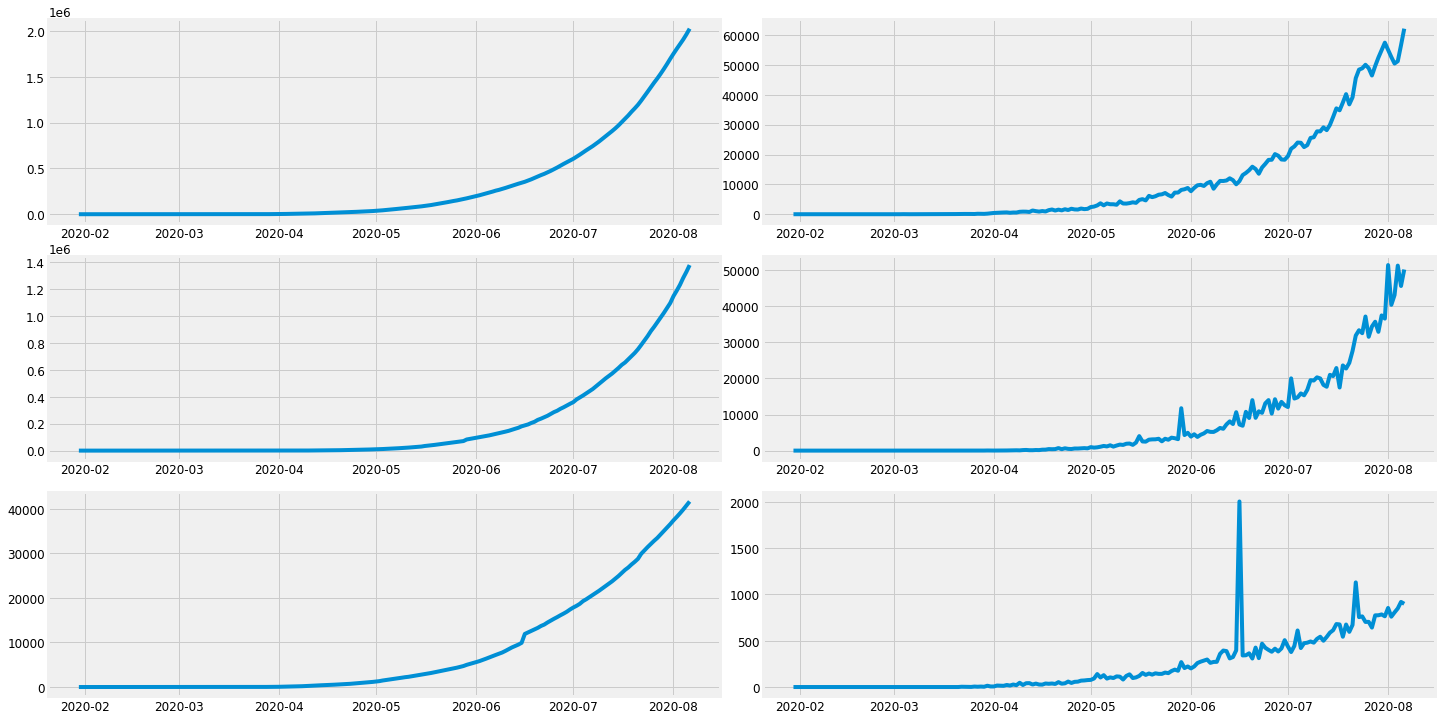

In [7]:
fig,ax=plt.subplots(3,2,figsize=(20,10))
fig.tight_layout()
ax[0,0].plot(indiadaily['Date'],indiadaily['Total Confirmed'])
ax[0,1].plot(indiadaily['Date'],indiadaily['Daily Confirmed'])
ax[1,0].plot(indiadaily['Date'],indiadaily['Total Recovered'])
ax[1,1].plot(indiadaily['Date'],indiadaily['Daily Recovered'])
ax[2,0].plot(indiadaily['Date'],indiadaily['Total Deceased'])
ax[2,1].plot(indiadaily['Date'],indiadaily['Daily Deceased'])

# plt.plot(indiadaily['Date'],indiadaily['Total Recovered'])
# plt.plot(indiadaily['Date'],indiadaily['Total Deceased'])

In [8]:
indiatesting=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/tests_day_wise.csv')
indiatesting=indiatesting[['Tested As Of','Total Samples Tested']]
indiatesting['Tested As Of']=indiatesting['Tested As Of'].str.replace('/','-')
indiatesting.rename(columns={'Tested As Of':'Date'},inplace=True)
indiatesting.dropna(how='any',axis=0,inplace=True)
indiatesting.isnull().sum()
indiatesting['Date']= indiatesting['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d-%m-%Y'))
indiatesting['Date']= pd.to_datetime(indiatesting['Date'])
indiatesting.head()

,Date,Total Samples Tested
0,2020-03-13,6500.0
1,2020-03-18,13125.0
2,2020-03-19,13316.0
3,2020-03-19,14175.0
4,2020-03-20,14376.0


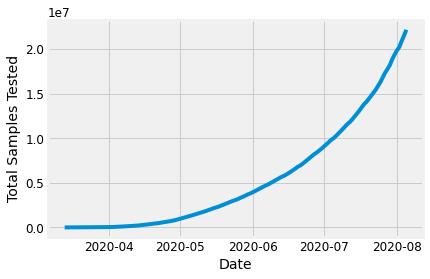

In [9]:
sns.lineplot(x='Date',y='Total Samples Tested',data=indiatesting)

# US COVID Data

In [10]:
usdaily=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/master/OtherDatasets/us.csv')
usdaily.rename(columns={'date':'Date'},inplace=True)
# indiadaily['Date'] = indiadaily['Date'].str.slice(0,6) +' 2020'
# indiadaily['Date']= indiadaily['Date'].astype(str).apply(lambda x: datetime.datetime.strptime(x,'%d %b %Y'))
usdaily['Date']= pd.to_datetime(usdaily['Date'])
print(usdaily.dtypes)
usdaily.tail()

Date      datetime64[ns]
cases              int64
deaths             int64
dtype: object


,Date,cases,deaths
257,2020-10-04,7444705,209606
258,2020-10-05,7487064,210035
259,2020-10-06,7529682,210756
260,2020-10-07,7582317,211750
261,2020-10-08,7638454,212678


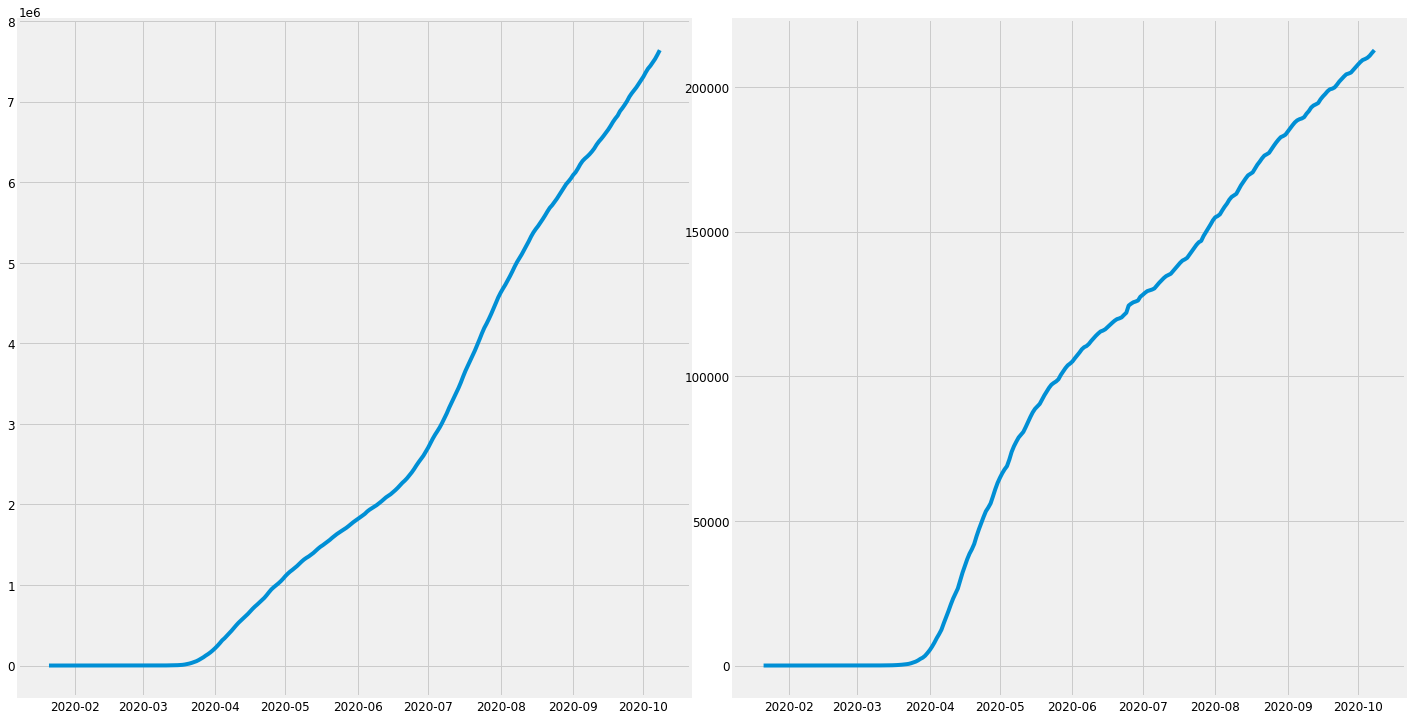

In [11]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
fig.tight_layout()
ax[0].plot(usdaily['Date'],usdaily['cases'])
ax[1].plot(usdaily['Date'],usdaily['deaths'])

# Merge India testing data with cases data 

In [12]:
indiacovidfinal = indiadaily.merge(indiatesting,how='inner',on='Date')
indiacovidfinal.tail()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,Total Samples Tested
141,2020-08-01,55117,1752185,51368,1146906,854,37420,19821831.0
142,2020-08-02,52672,1804857,40355,1187261,760,38180,20202858.0
143,2020-08-03,50488,1855345,43070,1230331,806,38986,20864750.0
144,2020-08-04,51282,1906627,51220,1281551,849,39835,21484402.0
145,2020-08-05,56626,1963253,45583,1327134,919,40754,22149351.0


In [13]:
finaldataindia=indiacovidfinal.groupby('Date').sum()
finaldataindia.sort_index(inplace= True)
finaldataindia.head()

,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,Total Samples Tested
Date,,,,,,,
2020-03-13,10,91,6,10,0,1,6500.0
2020-03-18,25,171,0,15,0,3,13125.0
2020-03-19,54,396,10,40,2,8,27491.0
2020-03-20,116,512,6,46,0,8,29780.0
2020-03-21,156,668,0,46,0,8,32612.0


<Figure size 1080x864 with 0 Axes>

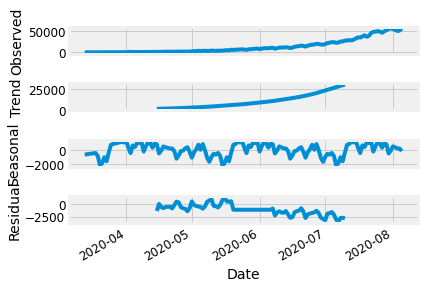

In [19]:
plt.figure(figsize=(15,12))
toplot=finaldataindia['Daily Confirmed']
result = seasonal_decompose(toplot, model='additive',freq=52)
result.plot()
plt.show()

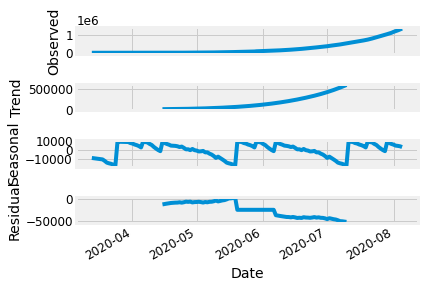

In [21]:
toplot=finaldataindia['Total Recovered']
result = seasonal_decompose(toplot, model='additive',freq=52)
result.plot()
plt.show()

In [22]:
finaldataus=usdaily.groupby('Date').sum()
finaldataus.sort_index(inplace= True)
finaldataus.head()

,cases,deaths
Date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0


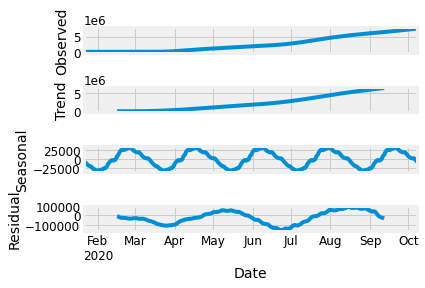

In [24]:
toplot=finaldataus['cases']
result = seasonal_decompose(toplot, model='additive',freq=52)
result.plot()
plt.show()

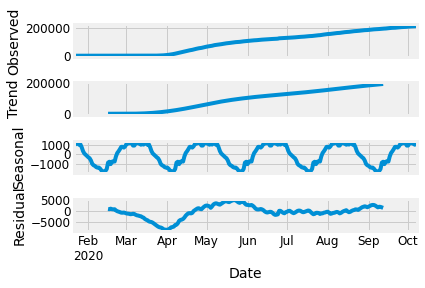

In [25]:
toplot=finaldataus['deaths']
result = seasonal_decompose(toplot, model='additive',freq=52)
result.plot()
plt.show()

# Stationarity Testing

In [27]:
result = adfuller(finaldataus['cases'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.395862
p-value: 0.997095
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [28]:
result = adfuller(finaldataus['deaths'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.652094
p-value: 0.858771
	1%: -3.457
	5%: -2.873
	10%: -2.573


# ARIMA Model

                             ARIMA Model Results                              
Dep. Variable:      D.Total Recovered   No. Observations:                  137
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1257.130
Method:                       css-mle   S.D. of innovations           2293.411
Date:                Tue, 13 Oct 2020   AIC                           2528.260
Time:                        18:05:28   BIC                           2548.700
Sample:                             1   HQIC                          2536.567
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    9687.0374   3.51e+04      0.276      0.783   -5.92e+04    7.86e+04
ar.L1.D.Total Recovered     0.3968      0.085      4.648      0.000       0.229       0.564


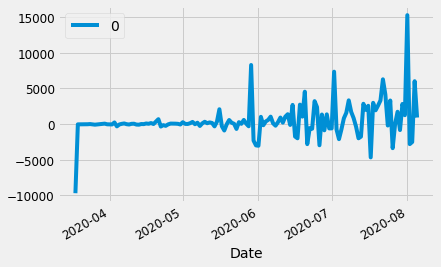

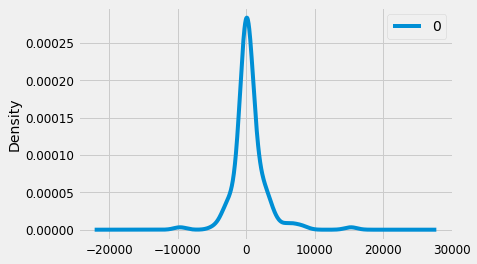

                  0
count    137.000000
mean     436.489513
std     2406.294177
min    -9682.037438
25%     -199.616984
50%       44.505832
75%      914.813687
max    15260.300580


In [33]:
model = ARIMA(finaldataindia['Total Recovered'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

                             ARIMA Model Results                              
Dep. Variable:      D.Total Confirmed   No. Observations:                  137
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1209.303
Method:                       css-mle   S.D. of innovations           1542.472
Date:                Tue, 13 Oct 2020   AIC                           2432.607
Time:                        18:05:51   BIC                           2453.047
Sample:                             1   HQIC                          2440.913
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1.433e+04        nan        nan        nan         nan         nan
ar.L1.D.Total Confirmed     1.0623    7.8e-06   1.36e+05      0.000       1.062       1.062


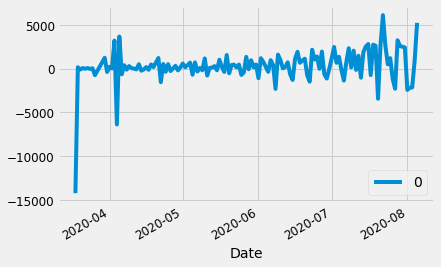

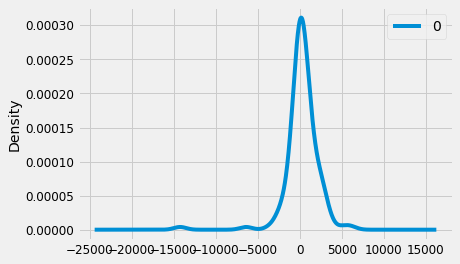

                  0
count    137.000000
mean     298.409268
std     1949.370278
min   -14249.650538
25%     -211.701373
50%      175.583719
75%     1099.225269
max     6101.099019


In [34]:
model = ARIMA(finaldataindia['Total Confirmed'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

                             ARIMA Model Results                              
Dep. Variable:       D.Total Deceased   No. Observations:                  137
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -895.699
Method:                       css-mle   S.D. of innovations            165.790
Date:                Tue, 13 Oct 2020   AIC                           1805.397
Time:                        18:06:35   BIC                           1825.837
Sample:                             1   HQIC                          1813.704
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    361.3037    239.081      1.511      0.133    -107.286     829.894
ar.L1.D.Total Deceased     0.2378      0.083      2.864      0.005       0.075       0.401
ar.L

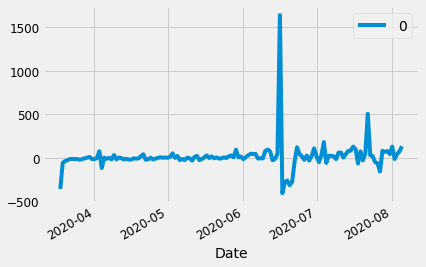

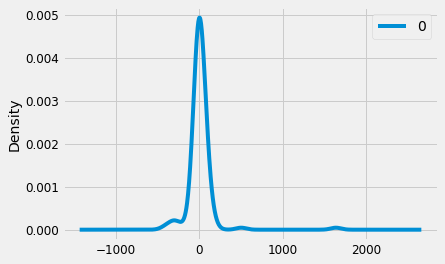

                 0
count   137.000000
mean     11.697075
std     168.247964
min    -408.303528
25%     -17.073837
50%      -0.213262
75%      30.401506
max    1638.209191


In [36]:
model = ARIMA(finaldataindia['Total Deceased'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

predicted=793725.836621, expected=794847.000000
predicted=820220.931029, expected=822609.000000
predicted=849917.983782, expected=850366.000000
predicted=878281.615528, expected=879472.000000
predicted=908319.072230, expected=907650.000000
predicted=936246.079685, expected=937567.000000
predicted=967021.293349, expected=970174.000000
predicted=1002210.182742, expected=1005642.000000
predicted=1040781.024849, expected=1040462.000000
predicted=1076024.439814, expected=1077873.000000
predicted=1115518.228474, expected=1118108.000000
predicted=1158757.807941, expected=1154914.000000
predicted=1192872.237792, expected=1194084.000000
predicted=1233460.659030, expected=1239685.000000
predicted=1283864.437372, expected=1288128.000000
predicted=1335851.278858, expected=1337016.000000
predicted=1388184.494830, expected=1387088.000000
predicted=1439507.125992, expected=1436020.000000
predicted=1485627.334309, expected=1482504.000000
predicted=1529217.481581, expected=1532135.000000
predicted=1581

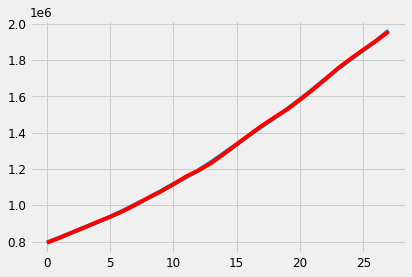

In [40]:
X = finaldataindia['Total Confirmed'].values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=5459995.288323, expected=5455187.000000
predicted=5493462.939161, expected=5498420.000000
predicted=5547515.787833, expected=5541433.000000
predicted=5586767.514083, expected=5587462.000000
predicted=5634086.105818, expected=5636491.000000
predicted=5683281.244042, expected=5681517.000000
predicted=5725095.091995, expected=5713850.000000
predicted=5744170.589024, expected=5754254.000000
predicted=5797423.186258, expected=5793437.000000
predicted=5834422.587204, expected=5838756.000000
predicted=5886979.647422, expected=5884366.000000
predicted=5926500.554452, expected=5930930.000000
predicted=5976426.396394, expected=5975540.000000
predicted=6017910.710496, expected=6008970.000000
predicted=6042006.536304, expected=6045455.000000
predicted=6083885.747407, expected=6089504.000000
predicted=6136042.142284, expected=6121948.000000
predicted=6155950.595217, expected=6168342.000000
predicted=6213570.797311, expected=6220446.000000
predicted=6268046.003661, expected=6262700.000000


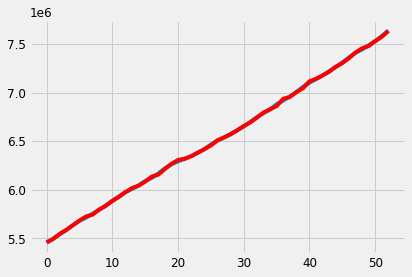

In [41]:
X = finaldataus['cases'].values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# Polynomial Regression